## Step -1 Install Dependencies

In [2]:
!pip install -q transformers datasets accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Step 2 Load GSM8K Subset

In [3]:
from datasets import load_dataset

gsm8k = load_dataset("gsm8k", "main",split="test[:50]")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [9]:
gsm8k[10]

{'question': 'A new program had 60 downloads in the first month. The number of downloads in the second month was three times as many as the downloads in the first month, but then reduced by 30% in the third month. How many downloads did the program have total over the three months?',
 'answer': 'The number of downloads of the program in the second month increased to 3*60 = <<3*60=180>>180\nIn the first two months, the total number of downloads of the program was 180+60 = <<180+60=240>>240\nIn the third month, the number of downloads of the program reduced by 30/100*180 = <<30/100*180=54>>54\nThere were 180-54 = <<180-54=126>>126 downloads in the third month.\nIn the three months, the total number of downloads of the program was 126+240 = <<126+240=366>>366\n#### 366'}

## Step 3 Define Few Shot Cot Prompt

In [10]:
## Few shot chain of thoughts prompt examples
few_shot_prefix=""" Q: Emily has 3 apples. Her friend gives her 2 more. How many apples does Emily have now?
A: Emily start with 3 apples .Her friend gives her 2 more. so, 3+2=5. The answer is 5.

Q: A pen costs 2 dollarrs. John buys 4 pens. How much does he pay?
A: A pen costs 2 dollars. John buys 4 pens. so, 2*4=8. The answer is 8.

Q: Jake read 5 pages on Monday and 7 pages on tuesday. How many pages did he read in total?
A: Jake read 5 pages on monday and 7 on tuesday.
so, 5+7=12. The answer is 12.

"""

## Step 4 Define the Function used to evaluate the models

In [11]:
from transformers import AutoTokenizer,AutoModelForSeq2SeqLM,pipeline
import torch
import re

def evaluate_model_fewshot(model_id):
  print(f"Evaluating{model_id} with few shor Cot...")
  tokenizer = AutoTokenizer.from_pretrained(model_id)
  model = AutoModelForSeq2SeqLM.from_pretrained(model_id)
  pipe=pipeline("text2text-generation",model=model,tokenizer=tokenizer,max_new_tokens=128)

  correct=0
  total=0

  for sample in gsm8k:
    question=sample["question"]
    gt_answer=sample['answer'].split("####")[-1].strip()

    prompt = few_shot_prefix + f"Q: {question}\nA:"

    output=pipe(prompt)[0]['generated_text']

    match = re.search(r"(\d+(?:\.\d+)?)", output.replace(",", ""))
    if match:
        pred=match.group(1)
        if pred==gt_answer:
            correct+=1
    total+=1
  accuracy=correct/total
  print(f"Accuracy: {accuracy}")
  return accuracy



The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## Step 5 Run Across Model Size and Plot

Evaluatinggoogle/flan-t5-small with few shor Cot...


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Accuracy: 0.02
Evaluatinggoogle/flan-t5-base with few shor Cot...


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Device set to use cuda:0


Accuracy: 0.04
Evaluatinggoogle/flan-t5-large with few shor Cot...


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Device set to use cuda:0


Accuracy: 0.04


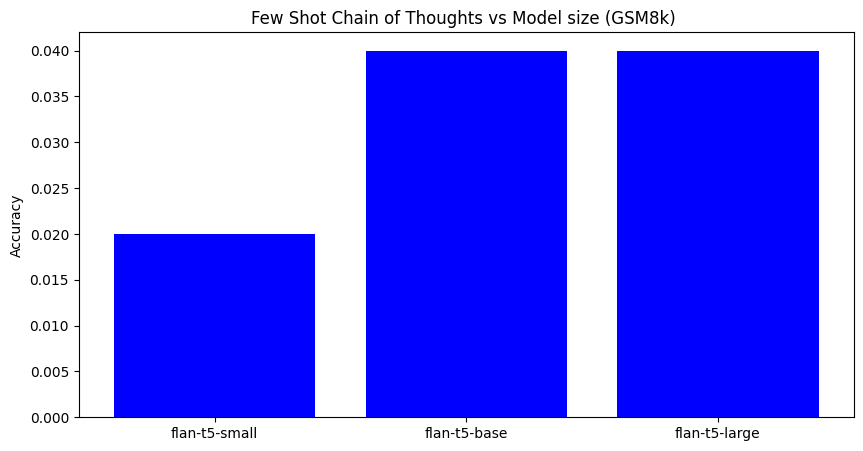

In [12]:
import matplotlib.pyplot as plt

model_ids={
    "flan-t5-small":"google/flan-t5-small",
    "flan-t5-base":"google/flan-t5-base",
    "flan-t5-large":"google/flan-t5-large",
}

results=[]
for label,model in model_ids.items():
    acc=evaluate_model_fewshot(model)
    results.append((label,acc))

## Ploting
labels=[r[0] for r in results]
scores=[r[1] for r in results]
x=range(len(labels))

plt.figure(figsize=(10,5))
plt.bar(x,scores,color="blue")
plt.xticks(x,labels)
plt.ylabel("Accuracy")
plt.title("Few Shot Chain of Thoughts vs Model size (GSM8k) ")
plt.show()

## Lets us see what type of result we are getting with these models

In [16]:
from transformers import AutoTokenizer,AutoModelForCausalLM,pipeline
def print_gsm8k_predictions(model_id,dataset,few_shot_prefix):
  import re
  from transformers import AutoTokenizer,AutoModelForCausalLM,pipeline
  import torch
  device = "cuda:0" if torch.cuda.is_available() else "cpu"

  print(f"\n Predictions from {model_id} on 5 GSM8k Questions")

  tokenizer = AutoTokenizer.from_pretrained(model_id)
  model = AutoModelForCausalLM.from_pretrained(model_id,
   device_map="auto",
   torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32)
  pipe=pipeline("text-generation",model=model,tokenizer=tokenizer,max_new_tokens=128,temperature=0.3)
  def extract_answer(text):
    text=text.replace(",","")
    numbers = re.findall(r"[-+]?\d+(?:\.\d+)?", text)
    return numbers[-1] if numbers else None
  for i, sample in enumerate(dataset.select(range(5))):
    question=sample["question"]
    gt_answer=sample["answer"].split("####")[-1].strip()
    prompt = few_shot_prefix + f"Q: {question}\nA:"
    output=pipe(prompt)[0]['generated_text']
    output_text=output.split("A:")[-1].strip()

    pred=extract_answer(output_text)
    print(f"\n Example {i+1}")

    print(f"Question: {question}")
    print(f"Ground Truth Answer: {gt_answer}")
    print(f"Model Output:\n {output_text}")
    print(f"Predicted Answer: {pred}")

    # Zephyr
print_gsm8k_predictions("HuggingFaceH4/zephyr-7b-alpha", gsm8k, few_shot_prefix)

# Phi-2
#print_gsm8k_predictions("microsoft/phi-2", gsm8k, few_shot_prefix)

# TinyLlama
#print_gsm8k_predictions("TinyLlama/TinyLlama-1.1B-Chat-v1.0", gsm8k, few_shot_prefix)




 Predictions from HuggingFaceH4/zephyr-7b-alpha on 5 GSM8k Questions


tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/628 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.3` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


NameError: name 'number' is not defined


## Final Plot: ALL the 6 Models

In [ ]:
# Combine model labels, sizes, and accuracy
all_results = results + decoder_results

# Define size annotations (approximate)
model_sizes = {
    "Flan-T5 Small": "80M",
    "Flan-T5 Base": "250M",
    "Flan-T5 Large": "800M",
    "Zephyr-7B": "7B",
    "Phi-2": "2.7B",
    "TinyLlama-1.1B": "1.1B"
}

# Update labels with sizes
labels = [f"{name}\n({model_sizes[name]})" for name, _ in all_results]
scores = [score for _, score in all_results]
x = range(len(labels))

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(x, scores, color="mediumseagreen")
plt.xticks(x, labels, rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.title("Few-Shot CoT Reasoning vs Model Size (GSM8K)")
plt.ylim(0, 1.0)
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()


### What did we learn?

(1) Chain of Thought Reasoning is only effective for bigger models.

(2) The model starts to give reasoning steps if input-output chain of thought examples are provided.

(3) Inspite of using model bigger models upto 7B parameters, accuracy remains low on arithmetic datasets